# Тестовое задание. Knowledge distillation

В данном отчете я исследую работу такого метода нейросетевой компрессии как knowledge distillation. Я решил исследовать эту задачу в CV. Задача классификации изображений основная для CV, так что исследовать метод на нем кажется адекватным. Я сделал это на предложенном датасете imagewoof. Он имеет оптимальные размеры для моих вычислительных мощностей. Также это довольно интересный датасет, из-за его небольшого размера интересно посмотреть на работу сетей на нем. 

В качестве student нейросети я беру предобученную Resnet 50. Она всего с 5 эпох достигает солидного результата в 94% accuracy. \
Я проверю работу knowledge distillation для student нейросетей 3 форматов: простая, очень компактная нейросеть, в 2 раза легче, чем teacher сеть предобученная Resnet 18, а также пустая Resnet 18.  \
На простой и компактной модели knowledge distillation не работает. Она только ухудшает перформанс и затягивает время обучения. Сложно сказать, связано ли это с маленьким объемом нейросети или же с тем фактом, что датасет очень небольшой и такой сети в принципе сложно показать адекватный результат.  \
Предобученная Resnet 18 оказалась не эффективной в вопросе компрессии. Она уже сходу начала давать результат сопоставимый с сетью учителем, так что метод knowledge distillation помог ей только на начальном этапе. \
Настоящий же эффект метода knowledge distillation был получен на "пустой" Resnet 18. За 8 эпох превосходство скомпрессированной сети почти на 13 процентов accuracy. \
Основываясь на проведенных опытах можно заключить, что метод действительно работает, но нужно быть очень внимательным к выбору student нейросети. \
Предложения по применению этого метода в конце отчета. \
Лично я производил запуск на сервисе colab. Из библиотек  использовал numpy и pytorch

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0" #необходимо для корректного открытия датасета
import torch
import numpy as np

In [ ]:
#инициализируем random seed
np.random.seed(42)

## Заугрузка датасета

Предложенный imagewoof датасет намекает на работу в fastai. Препроцессинг и загрузка датасета в этом разделе взяты с официального туториала на странице fastai.

In [ ]:
from fastai.vision import *

In [ ]:
path = untar_data('https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2')


In [ ]:
lbl_dict = dict(
  n02093754='Australian terrier', 
  n02089973='Border terrier', 
  n02099601='Samoyed', 
  n02087394='Beagle', 
  n02105641='Shih-Tzu', 
  n02096294='English foxhound', 
  n02088364='Rhodesian ridgeback', 
  n02115641='Dingo', 
  n02111889='Golden retriever', 
  n02086240='Old English sheepdog'
)

def lbl_trfm(o): 
  return lbl_dict[str(o).split('/')[-2]]
tfms = get_transforms()

In [ ]:
data = (ImageList.from_folder(path)
        .split_by_folder(valid='val')
        .label_from_func(lbl_trfm)
        .transform(tfms, size=160)
        .databunch(bs=32)
        .normalize(imagenet_stats))

In [ ]:
data

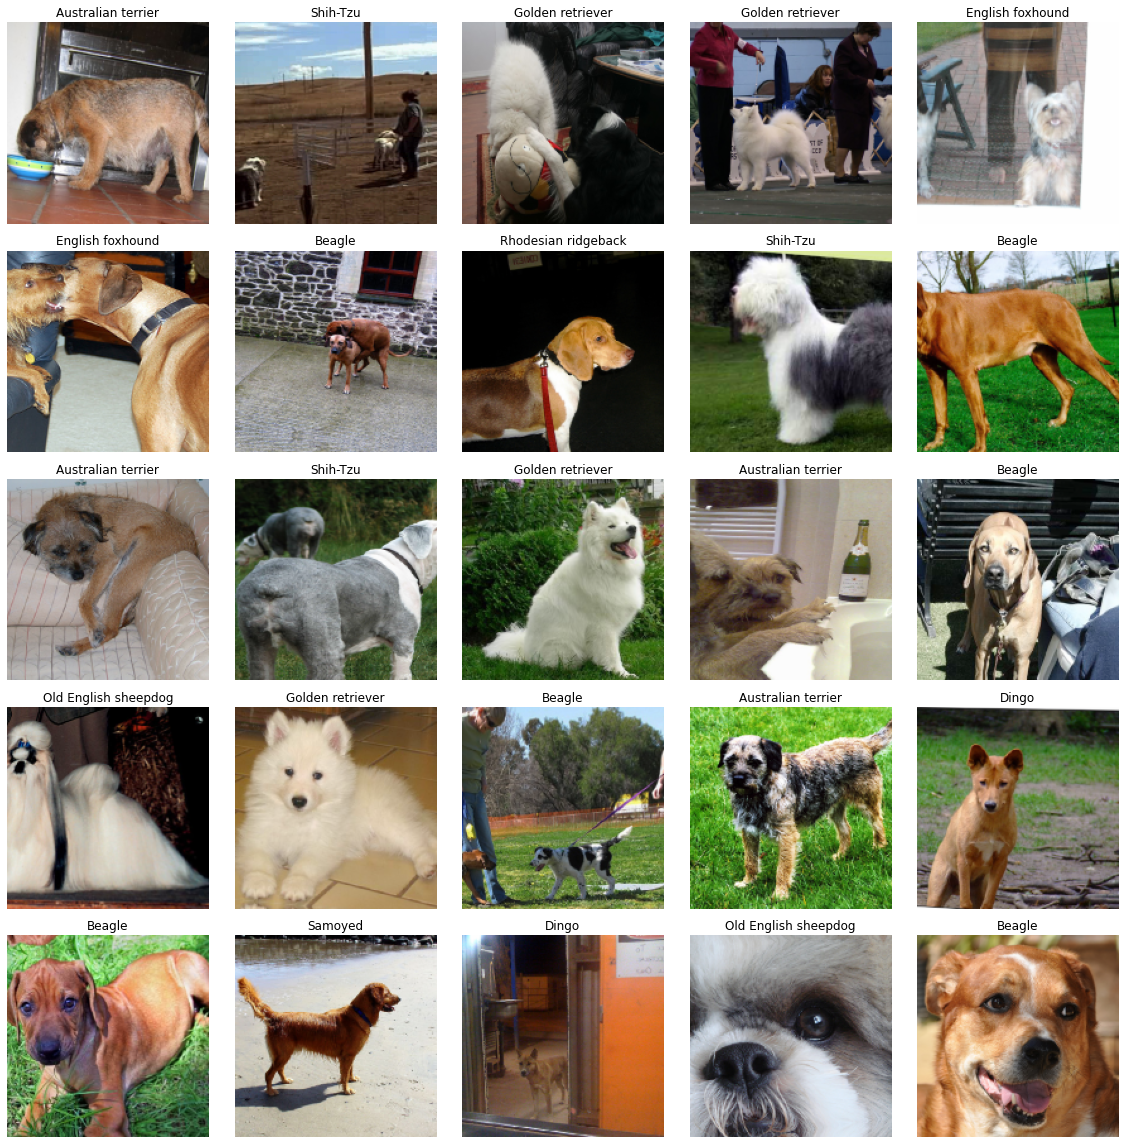

In [ ]:
#смотрим фото собачек
data.show_batch(5, figsize=(16,16))

## Обучение teacher модели

Для начала надо обучить большую и сложную (то, что в данной статье называется cumbersome) teacher-нейросеть. Я решил выбрать resnet50. Она показывает очень хороший результат на этом довольно сложном датасете, но в то же время ее реально за адекватное время обучить, используя мои возможности. 

In [ ]:
from fastai.callbacks import *
learn = cnn_learner(data, models.resnet50, metrics=[accuracy], pretrained=True, callback_fns=[CSVLogger,ShowGraph])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


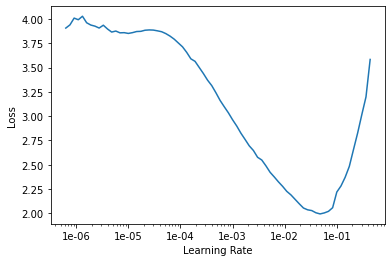

In [ ]:
#ищем оптимальный lr
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.184355,0.192279,0.941461,03:15
1,0.189541,0.207298,0.937389,03:23
2,0.198574,0.208175,0.937898,03:19
3,0.170609,0.198113,0.937134,03:22
4,0.154511,0.194713,0.941461,03:22


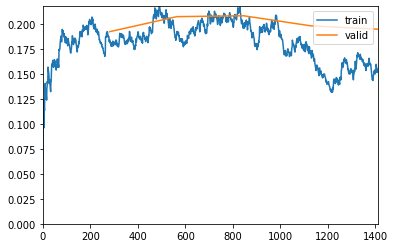

In [ ]:
#сетку обучаем на 5 эпохах
#после 5 эпох результат на валидационном датасете перестает меняться, так что можно оставить 5 эпох, в целях экономии времени
learn.fit_one_cycle(5,max_lr=slice(2e-4,2e-3,2e-2))

## Knowledge Distillation

Реализуем собственно knowledge distillation. Я решил не "изобретать велосипед" и воспользоваться функцией одного из специалистов с fasterai. Данная версия очень удобна, так как реализуется через очень удобную схему callback'ов.

In [ ]:
class KnowledgeDistillation(LearnerCallback):
    def __init__(self, learn:Learner, teacher:Learner, T:float=20., α:float=0.7):
        super().__init__(learn)
        self.teacher = teacher
        self.T, self.α = T, α
    
    def on_backward_begin(self, last_input, last_output, last_target, **kwargs):
        self.teacher.model.eval()
        teacher_output = self.teacher.model(last_input)
        new_loss = DistillationLoss(last_output, last_target, teacher_output, self.T, self.α)
        
        return {'last_loss': new_loss}

def DistillationLoss(y, labels, teacher_scores, T, alpha):
    return nn.KLDivLoss(reduction='batchmean')(F.log_softmax(y/T, dim=-1), F.softmax(teacher_scores/T, dim=-1)) * (T*T * 2.0 * alpha) + F.cross_entropy(y, labels) * (1. - alpha)

## Создаем собственную сеть для классификации

Попробуем реализовать алгоритм knowledge distillation с максимально несложной сетью, написанной в блоке кода ниже. Посмотрим, хватит ли у нее обобщающей способности, чтобы с помощью knowledge distillation выполнить классификацию на таком непростом датасете. 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 10)     

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = self.bn2(self.conv2(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = self.bn3(self.conv3(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = self.pool(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


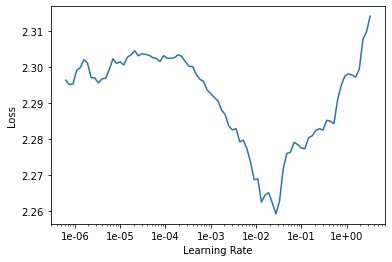

In [ ]:
s_learner = Learner(data, Net().cuda(), metrics=[accuracy])
s_learner.lr_find()
s_learner.recorder.plot()

In [ ]:
#обучаем сетку без помощи teacher нейросети
s_learner.fit_one_cycle(8, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.169368,2.118873,0.218631,02:33
1,2.073225,2.046291,0.244337,02:33
2,1.969183,1.946213,0.292695,02:33
3,1.877564,1.903205,0.306439,02:33
4,1.804987,1.847509,0.347417,02:33
5,1.731505,1.687383,0.396284,02:34
6,1.656638,1.603226,0.438279,02:33
7,1.624851,1.593360,0.452023,02:33


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,2.207728,2.159243,0.210741,02:39
1,2.148562,2.186218,0.247391,02:39
2,2.159875,2.237142,0.265971,02:39
3,2.125367,2.450285,0.268771,02:38
4,2.052870,2.083397,0.353016,02:39
5,1.952132,1.940334,0.376941,02:38
6,1.941113,1.844119,0.400611,02:39
7,1.850412,1.847756,0.402902,02:39


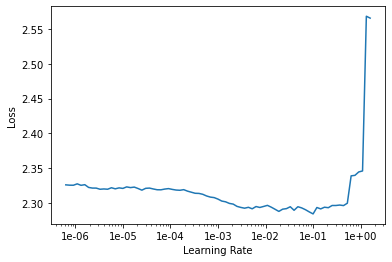

In [ ]:
#подключаем knowledge distillation
s_learner = Learner(data, Net().cuda(), metrics=[accuracy])
s_learner.lr_find()
s_learner.recorder.plot()
s_learner.fit_one_cycle(8, 1e-3, callbacks=[KnowledgeDistillation(s_learner, teacher=learn)])

Для данной student нейросети эксперимент оказался довольно неудачным. Обобщающая способность падает, а время обучения на каждой эпохе незначительно растет. Сложно сказать в чем причина, возможно, у этой сетки просто нет внутреннего ресурса для таких сложных задач на таких маленьких датасетах.

## Предобученная Resnet 18

Попробуем использовать в качестве student нейросети более сложную сеть. По количеству FLOPs Resnet 18 примерно в 2 раза "легче", чем Resnet 50, сравним ее обобщающую способность и посмотрим, сможет ли она достичь сопоставимого результата. 

Мы обучим как предобученную Resnet 18 (в этом случае корректнее сказать дообучим), так и не предобученную Resnet 18. 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


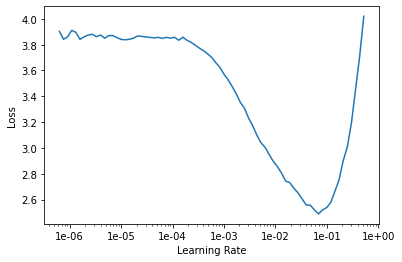

In [ ]:
s_learner = cnn_learner(data, models.resnet18, pretrained=True, metrics=[accuracy])
s_learner.lr_find()
s_learner.recorder.plot()

In [ ]:
#pretrained Resnet 18 без knowledge distillation
s_learner.fit_one_cycle(8, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.930319,0.459542,0.849835,02:34
1,0.617000,0.369770,0.892594,02:34
2,0.501527,0.332487,0.896411,02:34
3,0.384046,0.308193,0.902774,02:34
4,0.391206,0.311450,0.903538,02:34
5,0.336542,0.288213,0.910410,02:34
6,0.319675,0.278974,0.911173,02:35
7,0.294618,0.271492,0.913719,02:35


In [ ]:
#pretrained Resnet 18 с knowledge distillation
s_learner = cnn_learner(data, models.resnet18, pretrained=True, metrics=[accuracy])
s_learner.fit_one_cycle(8, 1e-3, callbacks=[KnowledgeDistillation(s_learner, teacher=learn)])

epoch,train_loss,valid_loss,accuracy,time
0,0.798534,0.388424,0.875541,02:45
1,0.491332,0.307999,0.906592,02:45
2,0.426297,0.302868,0.908374,02:45
3,0.392387,0.296208,0.913719,02:45
4,0.373658,0.294974,0.915755,02:44
5,0.372586,0.289384,0.919063,02:44
6,0.328921,0.297012,0.912191,02:43
7,0.340977,0.290201,0.918045,02:45


В этот раз эксперимент получился более удачный. При обучении на малом количестве эпох нейросеть показывает лучший результат, но потом результаты сеток с и без knowledge distillation сравниваются. Возможно, это связано с тем, что результат teacher нейросети не заметно выше чем у student нейросети.

## Непредобученная Resnet 18

Наиболее любопытная часть эксперимента. Не-предобученная Resnet 18. 

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


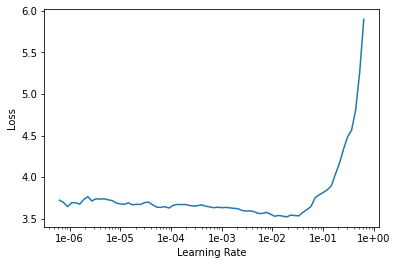

In [ ]:
s_learner = cnn_learner(data, models.resnet18, pretrained=False, metrics=[accuracy])
s_learner.lr_find()
s_learner.recorder.plot()

In [ ]:
s_learner.fit_one_cycle(8, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.025230,2.336804,0.203869,02:36
1,2.669888,3.121173,0.137185,02:36
2,2.348630,2.040609,0.240519,02:35
3,2.221534,2.617984,0.216340,02:38
4,1.977267,2.176067,0.341817,02:39
5,1.807637,1.643124,0.432680,02:42
6,1.620175,1.430808,0.494019,02:41
7,1.548773,1.400624,0.508272,02:44


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


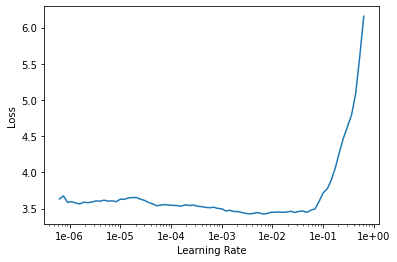

In [ ]:
#не pretrained Resnet 18 без knowledge distillation
s_learner = cnn_learner(data, models.resnet18, pretrained=False, metrics=[accuracy])
s_learner.lr_find()
s_learner.recorder.plot()O

In [ ]:
s_learner.fit_one_cycle(8, 1e-3, callbacks=[KnowledgeDistillation(s_learner, teacher=learn)])

epoch,train_loss,valid_loss,accuracy,time
0,3.059074,2.468363,0.221176,03:27
1,2.764714,2.357537,0.263171,03:22
2,2.537835,2.409684,0.328328,03:19
3,2.346951,2.578826,0.361670,03:23
4,2.087886,1.889051,0.481038,03:13
5,1.959315,1.552152,0.576483,03:13
6,1.670298,1.382270,0.618478,03:13
7,1.477706,1.328524,0.638585,03:13


Как мы видим, в этом случае knowledge distillation действительно улучшает перформанс нейросети. Причем делает это довольно заметно. В этом случае действительно можно утверждать, что knowledge distillation работает.

## Выводы

Можно повторить выводы из начала отчета. Knowledge distillation работает, но нужно тщательно подходить к выбору student нейросети. Она должна быть достаточно большой, чтобы в принципе иметь возможность обучиться на датасете.

Предложенный для рассмотрения метод компрессии показался мне очень интересным. Я думаю, что у него возможно много разных любопытных применений. Помимо наиболее очевидного внедрения более простых сетей в носимые устройства и мобильные телефоны я вижу большой потенциал в построении решающих деревьев (а тем самым значительного повышения интерпретируемости сетей) на основе KD.  

Работа была невероятно интересной, очень был рад возможности поработать над такой интересной темой! \
Жду обратной связи!